In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import utils

%config InlineBackend.figure_formats = ['svg']
from IPython.display import HTML
from scipy.signal import spectrogram

# ECE 6961 Wireless Communications
## Project Part 1. Task 2

Group Members: Grant Brown, Thomas Warren, Rick Lyon

Setup
---------

To generate this report and the associated plots:

1. Install Python 3.11.
2. Open a terminal window and navigate to the directory containing the project files. 
2. Create an virtual environment for the report/project. See [here](https://docs.python.org/3/library/venv.html) for more information.  
`> python -m venv .venv`
4. In the newly created environment, install the required packages from the requirements.txt file included with the project files.  
`(.venv) > pip install -r requirements.txt`
5. Open the report with Jupyter Notebooks.  
`(.venv) > jupyter notebook task2.ipynb`
6. The notebook should open in the default browser. 

7. To generate the .html version of the report,  
`(.venv) > jupyter nbconvert --to html task2.ipynb`

# Task 2
----
Follow the steps 1-7 shown in the file underwater data gen.pdf to generate passband data for the
ZP-OFDM underwater transmission.

### Step 1. Generate QPSK Symbols

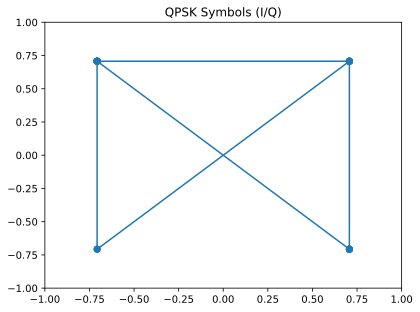

In [2]:
K = 16 # number of subcarriers
W = 4 # number of OFDM symbols
L = 5 # number of taps in channel 
D = L - 1 # length of prefix
fc = 24e3 # carrier frequency
fs = 192e3 # sampling rate
Ts = (1 / 8000) # symbol period
lam = 24 # samples per symbol
Tsamp = Ts / lam # sample period (symbol period divided by the samples per symbol) 

# data sequence must have M*N*2 bits for there to be M*N QPSK symbols (2 bits per symbol).
# characters are 8 bits each so we need M*N / 4 characters
input_data = b'AaBbCeDdEeFfGgHh' # 16 characters

# map data into a stream of QPSK symbols
qpsk_symbols = utils.qpsk_encoder(input_data)

plt.plot(np.real(qpsk_symbols), np.imag(qpsk_symbols))
plt.scatter(np.real(qpsk_symbols), np.imag(qpsk_symbols))
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.title("QPSK Symbols (I/Q)");

### Step 2. Convert subcarrier symbols to time domain OFDM data

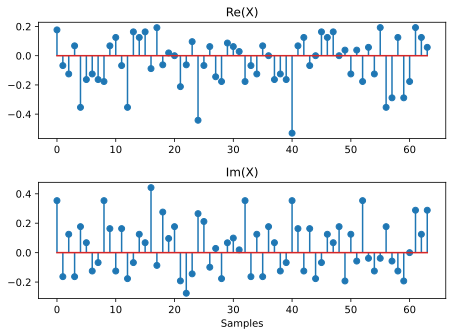

In [3]:
# use the idft on each group of M symbols, first reshape to a MxN matrix. Rows are the OFDM symbols, and columns
# are the QPSK symbols on each subcarrier
qpsk_symbols = np.reshape(qpsk_symbols, (W, K))
X = np.fft.ifft(qpsk_symbols, K, axis=-1)

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.stem(np.real(X.flatten()))
ax2.stem(np.imag(X.flatten()))
ax1.set_title("Re(X)")
ax2.set_title("Im(X)")
ax2.set_xlabel("Samples")
plt.tight_layout()

### Step 3. Add Zero Pad Prefix

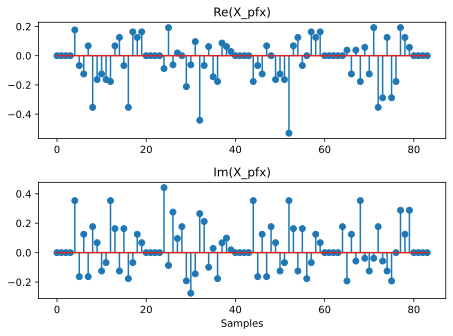

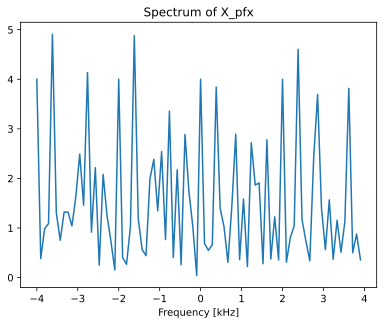

In [4]:
x_pfx_ = np.zeros((len(X), K + L -1), dtype='complex128')
for i, ofdm_sym in enumerate(X):
    x_pfx_[i] = np.concatenate([[0] * (L -1), ofdm_sym])

##############
# Step 3
##############
# flatten time sequence array. From here on, use the notation in the data_gen_final document.

# concatenate a zero pad at the end of the data vector
X_pfx = np.concatenate([x_pfx_.flatten(), [0] * D])

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.stem(np.real(X_pfx.flatten()))
ax2.stem(np.imag(X_pfx.flatten()))
ax1.set_title("Re(X_pfx)")
ax2.set_title("Im(X_pfx)")
ax2.set_xlabel("Samples")
plt.tight_layout()

utils.plot_fft(X_pfx, 8e3)
plt.title("Spectrum of X_pfx");

### Step 4. Oversample

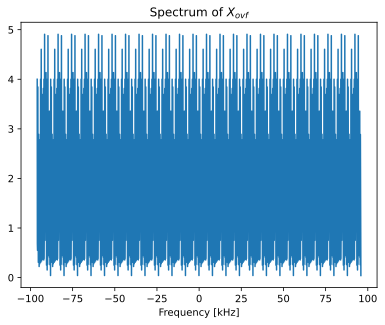

In [5]:
lam = 24
Xovf = np.zeros(len(X_pfx)*lam, dtype='complex128')
# indices of nonzero values
n_nonzero = np.arange(0, len(X_pfx)*lam, lam)
Xovf[n_nonzero] = X_pfx

utils.plot_fft(Xovf, fs)
plt.title("Spectrum of $X_{ovf}$");

### Step 5. Filter with SRRC

Text(0.5, 1.0, 'Spectrum of $X_{bb}$')

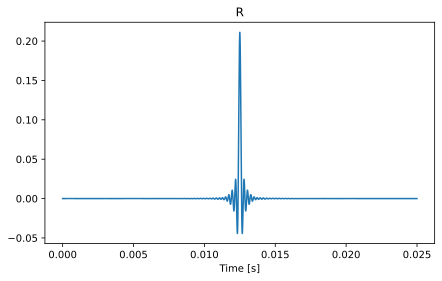

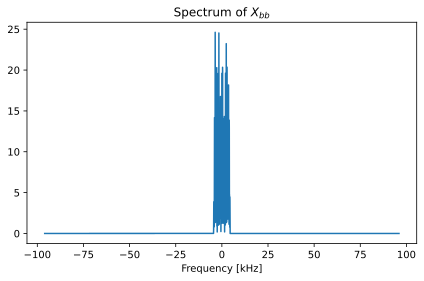

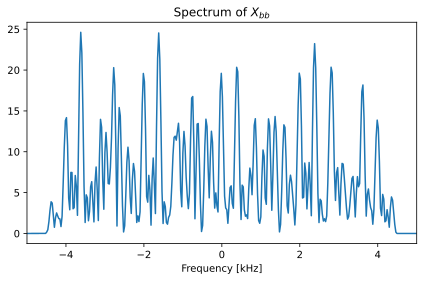

In [6]:
beta = 0.125 # roll off factor
n = np.arange(-lam*100, lam*100) 
t = np.arange(len(n)) * (1 / fs)
R = utils.srrc_pulse(n, lam, beta)

fig, ax = plt.subplots(1,1, figsize=(7, 4))
ax.plot(t, R)
ax.set_xlabel("Time [s]")
ax.set_title("R")

Xbb = np.convolve(Xovf, R)

utils.plot_fft(Xbb, fs, figsize=(7, 4))
plt.title("Spectrum of $X_{bb}$")

utils.plot_fft(Xbb, fs, figsize=(7, 4))
plt.xlim([-5, 5])
plt.title("Spectrum of $X_{bb}$")

## Step 6. Upconvert to Passband

In [7]:

Ts = (1 / 8000) # symbol period
Tsamp = Ts / lam # sample period (symbol period divided by the samples per symbol) 
n = len(Xbb)
Xpb = Xbb * np.exp(1j * 2*np.pi * fc * n * Tsamp)

# in-phase and quadrature signals sent over the analog channel
Xpb_I = np.real(Xpb)
Xpb_Q = np.imag(Xpb)

### Step 7. Chirp Preamble

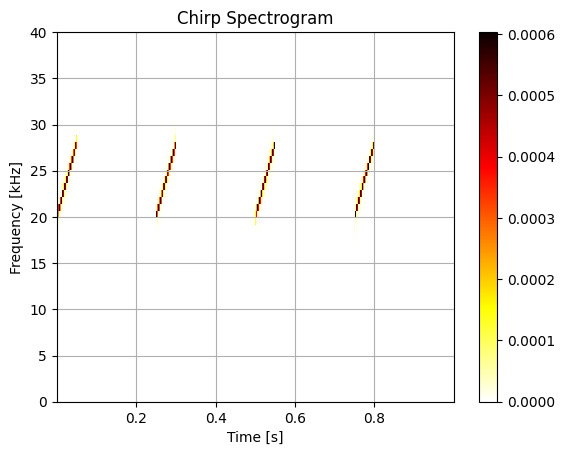

In [8]:

chirp_N = fs * 0.05 # number of samples per chirp
t = np.arange(chirp_N) / float(fs)
f_chirp = np.linspace(fc - 4e3, fc, len(t))
chirp = np.cos(2*np.pi*f_chirp*t)

# follow chirp with 0.2 seconds of silence
silence = np.zeros(int(0.2 * fs))
chirp_seq = np.concatenate([chirp, silence])

# chirp signal is sequence of 4 chirps
chirp_4x = np.concatenate([chirp_seq]*4)

f, t, Sxx = spectrogram(chirp_4x, fs=fs)

fig, ax = plt.subplots(1,1)
im = ax.pcolormesh(t, f / 1e3, Sxx, cmap='hot_r')
fig.colorbar(im)

ax.set_ylim([0, 40])
ax.grid(True)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Frequency [kHz]');
ax.set_title("Chirp Spectrogram")
%config InlineBackend.figure_formats = ['png']

In [9]:
%config InlineBackend.figure_formats = ['svg']

### Step 8. Downconvert to Baseband and Validation

Text(0.5, 0, 'Samples')

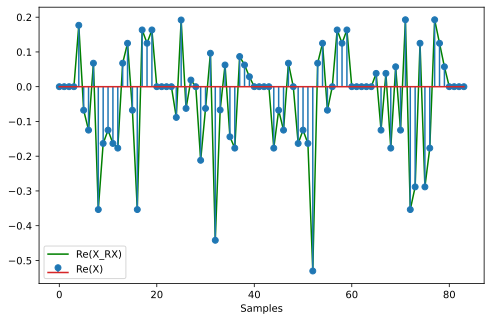

In [10]:
Xpb_RX = Xpb_I + 1j * Xpb_Q
Xbb_RX = Xpb_RX * np.exp(-1j * 2*np.pi * fc * n * Tsamp)

# matched filtering
Xovf_RX = np.convolve(Xbb_RX, R)

# clip the delay caused by the pulse shape delay
delay_s = 2 * (100 * lam)
# sample at each symbol peak (downsample)
X_RX = Xovf_RX[delay_s:-delay_s:lam]


plt.figure(figsize=(8, 5))
plt.plot(np.real(X_RX), color='green', label="Re(X_RX)")
plt.stem(np.real(X_pfx.flatten()), label="Re(X)")
# plt.xlim([0, 40])
plt.legend()
plt.xlabel("Samples")

### Apply DFT to get QPSK Symbols

In [11]:
# ignore the first L-1 samples from the channel. These samples are the first zero pad and contain no data.
y = X_RX[4:]

# regroup the symbols into N groups of M+L-1, beginning with the first sample received.
y_m = np.reshape(y, (W, K+L-1))

# create modified DFT matrix (overlap add)
k, m = np.meshgrid(np.arange(K+L-1), np.arange(K))
Gm = np.exp(-1j * 2*np.pi * m * k / K)

# apply DFT with matrix multiplication
Ym = np.einsum("ij,...j->...i", Gm, y_m)

output_data = utils.qpsk_decoder(Ym.flatten())

print("Input Data: ", input_data)
print("Output Data: ", output_data)

Input Data:  b'AaBbCeDdEeFfGgHh'
Output Data:  b'AaBbCeDdEeFfGgHh'


### 

In [ ]:
from IPython.display import display, HTML, Javascript
from ipylab import JupyterFrontEnd
import subprocess
app = JupyterFrontEnd()

display(
    HTML(
        "<style>"
        ".jp-Cell { overflow-x: visible; overflow: visible; "
        "width: 95%; max-width: 800px; "
        "margin-left: auto; margin-right: auto; }"
        "img {"
        "width: 90%;"
        "height: 100%;}"
        ".jp-Cell-inputWrapper { width: 95%; overflow-x: visible; overflow: visible;}"
        "</style>"
    )
)

app.commands.execute("docmanager:save")
subprocess.run("jupyter nbconvert --to html task2.ipynb", shell=True)
app.commands.execute("docmanager:save");